In [1]:
!vlc --demux rawvideo --rawvid-fps 30 --rawvid-width 640 --rawvid-height 480 --rawvid-chroma I420 test_many.yuv

'vlc' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
# Import using scikit-video
import skvideo.io
import skvideo.datasets
import os
import subprocess as sp

In [4]:
videodata = skvideo.io.vread("V:\\Downloads\\wetransfer_share_2022-05-31_1548\\share\\test_many_12mp_30000.mjpeg")
print(videodata.shape)

(239, 3040, 4056, 3)


In [26]:
videodata = skvideo.io.FFmpegReader("V:\\Downloads\\test_many.yuv", inputdict={"--demux": "rawvideo", "--rawvid-fps": 30, "--rawvid-width": 640, "--rawvid-height": 480, "--rawvid-chroma": "I420"})
print(videodata.shape)

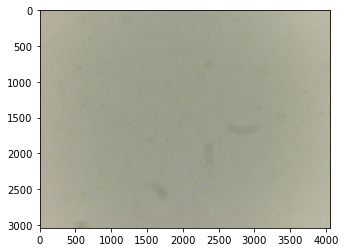

In [6]:
import matplotlib.pyplot as plt
videodata[0].shape
plt.imshow(videodata[100])

In [30]:
# Crop image
import numpy as np
cut = 400
#videodata_ = np.ndarray([videodata.shape[0], [int(videodata.shape[2]/2)-200: int(videodata.shape[2]/2)+200], [int(videodata.shape[3]/2)-200:int(videodata.shape[3]/2)+200], videodata.shape[3]])
videodata_ = videodata[:, int(videodata.shape[1]/2)-cut: int(videodata.shape[1]/2)+cut, int(videodata.shape[2]/2)-cut:int(videodata.shape[2]/2)+cut, :]
videodata_.shape

(239, 800, 800, 3)

(800, 800, 3)


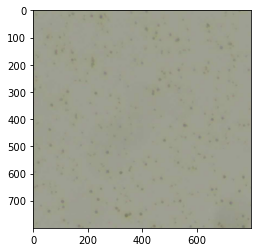

In [31]:
%matplotlib inline
print(videodata_[0].shape)
plt.imshow(videodata_[0])

In [9]:
# Recommended ways of Trackpy
import pims
import trackpy as tp

(800, 800)


<IPython.core.display.Javascript object>


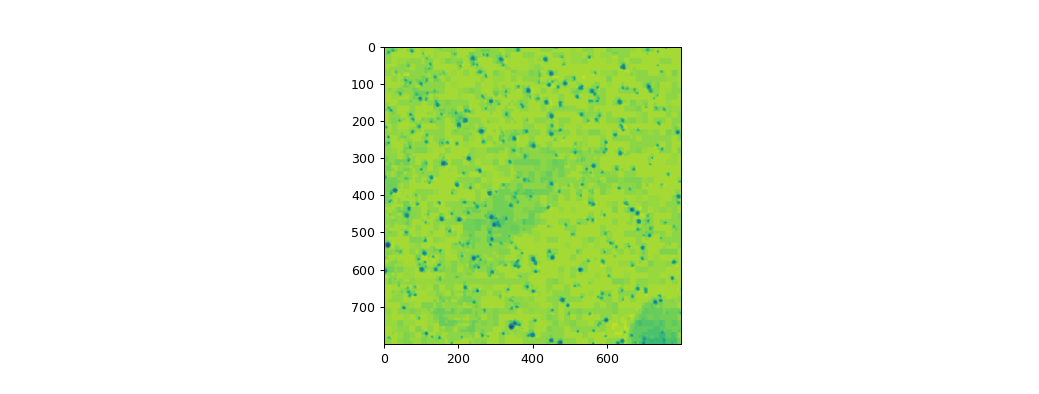

In [61]:
green_channel = videodata_[:, :, :, 1]
print(green_channel[100].shape)
plt.imshow(green_channel[200])

(800, 800)


<IPython.core.display.Javascript object>


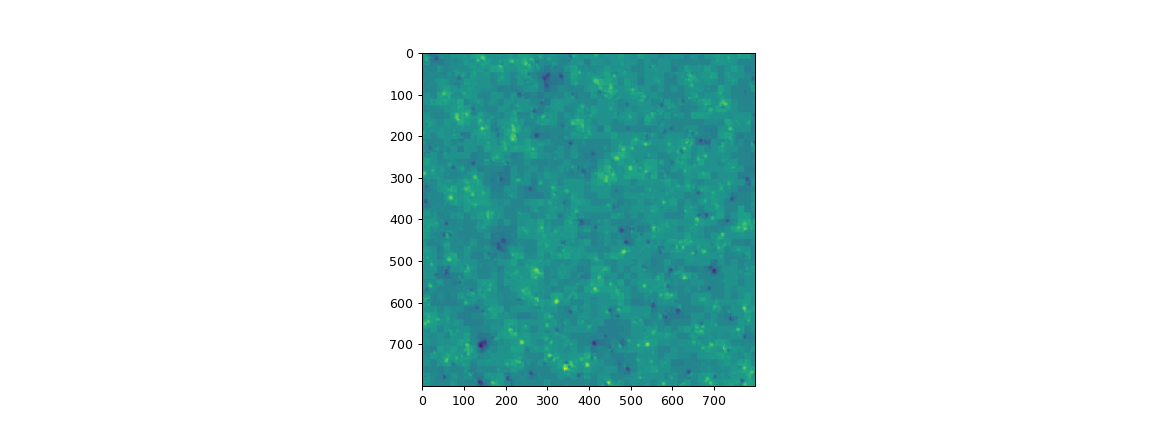

In [42]:
# Noise reduction
bg = green_channel[0] + green_channel[-1] / 2
green_channel_n = green_channel - bg
print(green_channel_n[0].shape)
plt.imshow(green_channel_n[100])
green_channel = green_channel_n

127


<IPython.core.display.Javascript object>


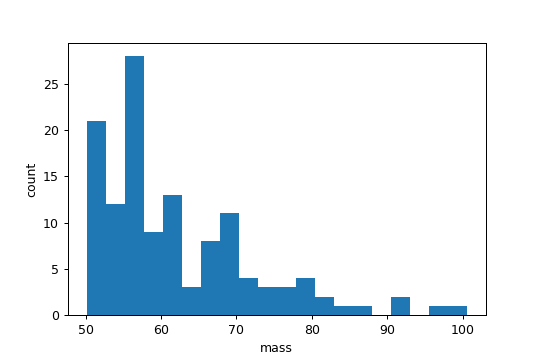

[Text(0.5, 0, 'mass'), Text(0, 0.5, 'count')]

In [45]:
f = tp.locate(green_channel[0], 11, invert=True,  minmass=50)
print(len(f))
f.head()

fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count')

<IPython.core.display.Javascript object>


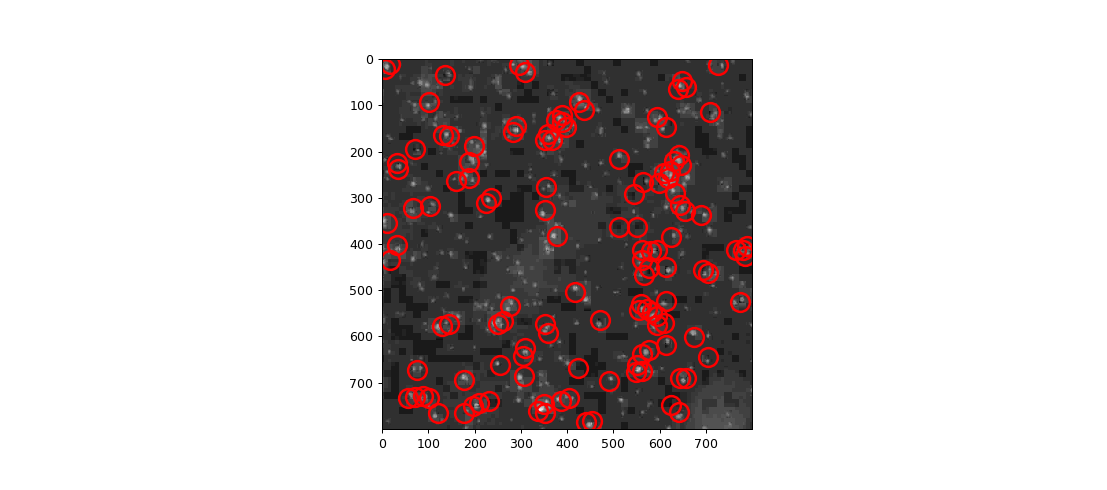

<AxesSubplot:>

In [46]:
tp.annotate(f, green_channel_n[0])

In [55]:
f_ = tp.batch(green_channel[:300], 21, minmass=75, invert=True);


Frame 238: 392 features


In [56]:
t = tp.link(f_, 15, memory=10) #Create trajectories
t1 = tp.filter_stubs(t, 25)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())


Frame 238: 392 trajectories present.
Before: 5909
After: 1199


<IPython.core.display.Javascript object>


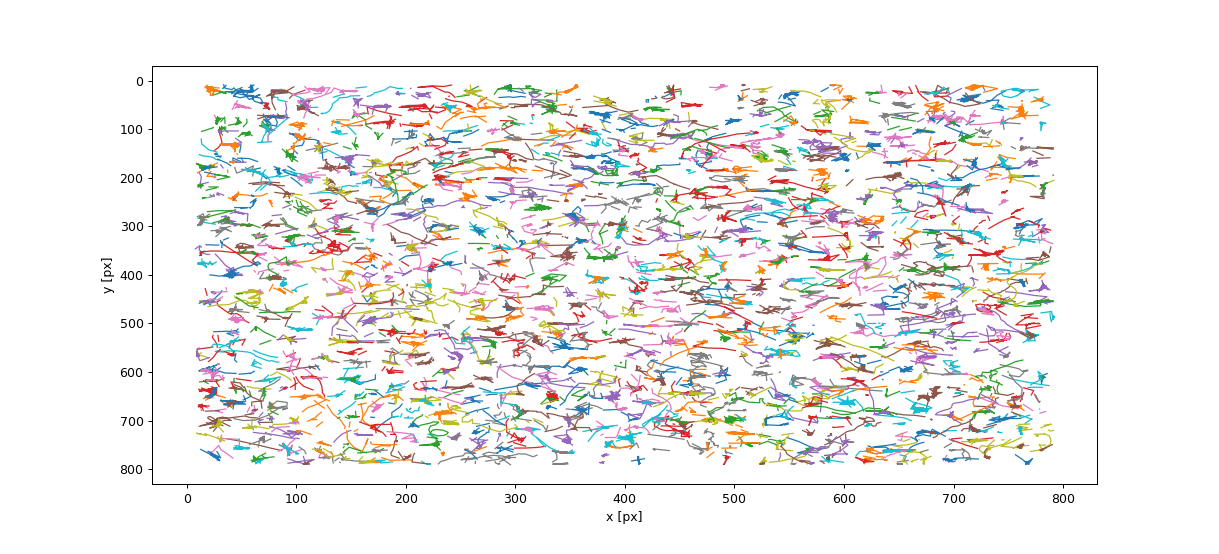

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [57]:
%matplotlib notebook
plt.figure()
tp.plot_traj(t1)

36950


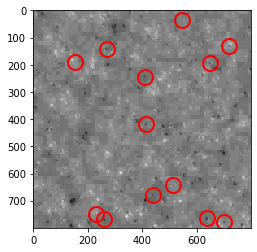

<AxesSubplot:>

In [58]:
%matplotlib inline
# Additional filtering
t2 = t1[((t1['mass'] > 50) & (t1['size'] < 4) &
         (t1['ecc'] < 0.3))]
print(t2.size)
plt.figure()
tp.annotate(t2[t2['frame'] == 100], green_channel[100])

<IPython.core.display.Javascript object>


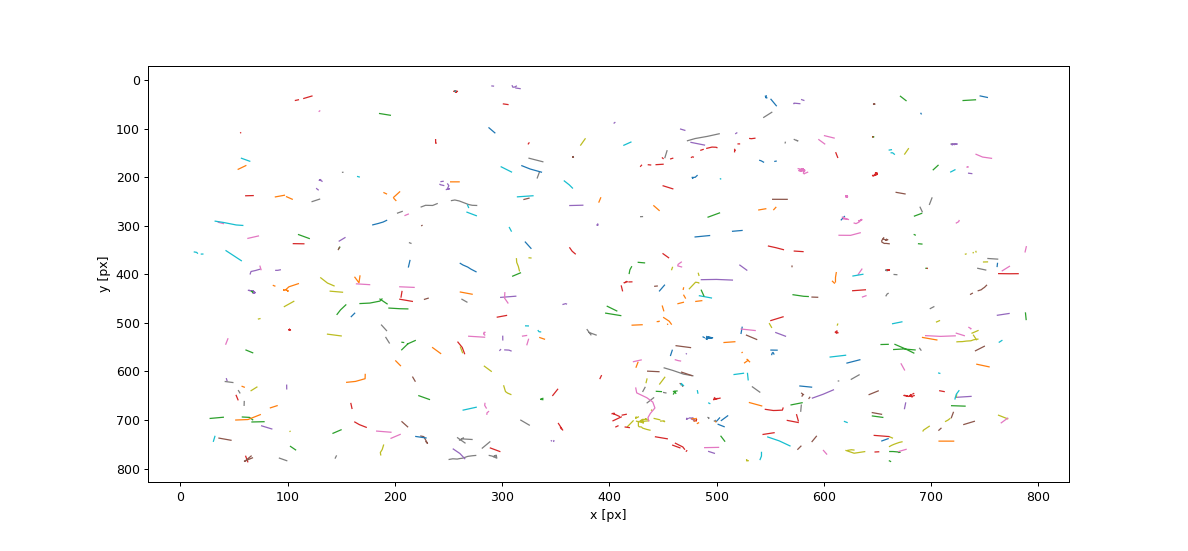

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [59]:
%matplotlib notebook
plt.figure()
tp.plot_traj(t2)

* life: The number of frames the particle exists in the field of view.
* 
* diameter: Pased to the `locate()` function, is the expected diameter of the particle (in units of pixels). 
* mass: alias of brightness. ? Probably total brightness per unit area.
* memory → no_of_frames: Retain particle if it disappears due to post-processing.
* threshold: ?
* search_range: Range of search [subnet] for a particle candidate during the linking phase.
* size: 
* ecc:
* ep (epsilon) : Error in estimation of particle position.
* max_iterations: Number of attempts made to locate the centroid of the particle.
### Functions:

* locate & batch: Extract features frame wise.
* subpx_bias: ? Not exactly sure.
* link: Create trajectories from individual features.
* plot_traj: Plot trajectories directly from trajectories df.
* 
### Filters:

1. Spurious trajectories only appear for a few frames. They can be removed using a min_frame filter criterion.
    *  filter_stubs(features, min_frames)
2. With trajectories plotted, the "average appearance" of each detected particle can be analysed to differentiate betwen a spurious detection or a real particle.
    * Remove particles with very low avg mass or very high avg mass.
3. Particles with very high and low mass & size (comared to the mass distribution function) should be detected and removed.
4. Particles with very 


### Subpixel accuracy and detection
>If a particle's image spans multiple pixels, we can find its position with subpixel accuracy by taking the average position of these pixels, weighted by brightness. This is referred to as the particle's centroid.

* Accuracy is affected by the diameter parameter. It is recommended to use a higher value (with penalty in performance) than a lower value which causes more inaccuracies.

* A too-small diameter often biases the location [centroid] toward the pixel edges.
* Random errors in particle tracking can lead to systematic errors in the derived statistics, such as mean squared displacement, that are qualitatively misleading. For random walks, this adds a constant offset.


## TODO

1. Particle tracking and **prediction**.